<a href="https://colab.research.google.com/github/hardzal/bert_movielens/blob/master/anime_recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np

import random
from random import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import KNNBaseline
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy

from surprise import Reader
from surprise import Dataset

In [7]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [9]:
anime_df.shape

(12294, 7)

In [10]:
anime_df.dropna(inplace=True)

In [11]:
anime_df.shape

(12017, 7)

In [12]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
rating_df.shape

(2475694, 3)

In [14]:
df_merge = pd.merge(anime_df, rating_df, on = 'anime_id')
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [15]:
df_merge.shape

(2475642, 9)

In [16]:
df_merge.rating_x.min()

2.0

In [17]:
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


In [18]:
df_merge.shape

(2013004, 9)

In [19]:
sample = df_merge.sample(frac=.25)
sample

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
305459,1889,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller",TV,24,8.41,218101,4883,10
963808,2508,Genshiken 2,"Comedy, Parody, Slice of Life",TV,12,7.86,55825,7161,8
738643,29803,Overlord,"Action, Adventure, Fantasy, Game, Magic, Super...",TV,13,8.04,244268,11262,7
1192448,7661,Giant Killing,"Drama, Seinen, Sports",TV,26,7.71,36947,5492,7
668368,15,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145,8.08,83648,21068,8
...,...,...,...,...,...,...,...,...,...
1203423,11743,Toaru Majutsu no Index: Endymion no Kiseki,"Action, Magic, Sci-Fi, Super Power",Movie,1,7.71,54873,16133,9
318945,1210,NHK ni Youkoso!,"Comedy, Drama, Psychological, Romance",TV,24,8.40,291228,5680,10
570186,934,Higurashi no Naku Koro ni,"Horror, Mystery, Psychological, Supernatural, ...",TV,26,8.17,359494,5189,8
2131462,391,Tales of Phantasia The Animation,"Adventure, Fantasy, Shounen",OVA,4,6.96,16455,20037,6


In [20]:
sample = df_merge.sample(n=5000)
sample.shape

(5000, 9)

In [21]:
sample.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating_x    float64
members       int64
user_id       int64
rating_y      int64
dtype: object

In [22]:
sample['rating_x'] = sample['rating_x'].astype(int)

In [23]:
sample.dtypes

anime_id     int64
name        object
genre       object
type        object
episodes    object
rating_x     int64
members      int64
user_id      int64
rating_y     int64
dtype: object

In [24]:
ratings_x = sample['rating_x'].value_counts()
ratings_y = sample['rating_y'].value_counts()
print(ratings_x)
print(ratings_y)

7    2717
8    1552
6     610
9      61
5      47
4       8
3       4
2       1
Name: rating_x, dtype: int64
8     1285
7     1083
9     1043
10     727
6      503
5      204
4       90
3       34
2       20
1       11
Name: rating_y, dtype: int64


In [25]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
852257,30123,Akagami no Shirayuki-hime,"Drama, Fantasy, Romance, Shoujo",TV,12,7,157551,14998,10
2321054,10739,Panty &amp; Stocking in Sanitarybox,"Action, Comedy, Dementia, Ecchi, Parody, Super...",Special,1,6,19669,7042,8
1171632,1606,Kekkaishi,"Adventure, Comedy, Fantasy, Shounen",TV,52,7,61884,4210,7
1662933,443,Onegai☆Teacher: Himitsu na Futari,"Comedy, Ecchi, Romance, Sci-Fi",OVA,1,7,32134,8287,8
941433,15451,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7,266657,9471,7


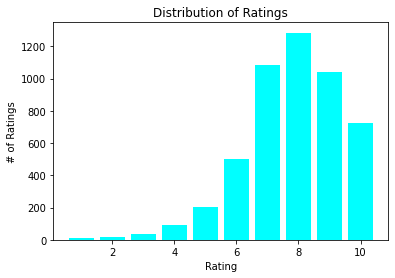

In [26]:
## EDA
# plot distribution in matplotlib
ratings_sorted = sorted(list((zip(ratings_y.index, ratings_y))))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='cyan')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [27]:
print("Number of users:", df_merge.user_id.nunique())

Number of users: 22264


In [28]:
print("Average Number of Reviews per User: {:.2f}".format(df_merge.shape[0]/df_merge.user_id.nunique()))

Average Number of Reviews per User: 90.42


In [29]:
sample['user_id'].value_counts()

12431    8
7081     7
8217     7
2951     7
1456     7
        ..
1274     1
3873     1
4668     1
19456    1
22885    1
Name: user_id, Length: 3818, dtype: int64

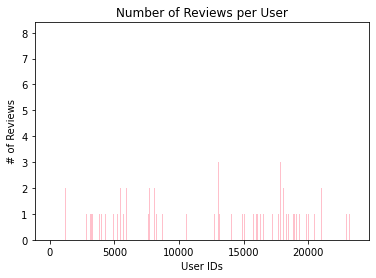

In [30]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [31]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different animee:", sample.type.nunique())
print("Type of type:", sample.type.value_counts())

Number of users: 3818
Number of types of different animee: 6
Type of type: TV         3477
Movie       648
OVA         469
Special     329
ONA          62
Music        15
Name: type, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


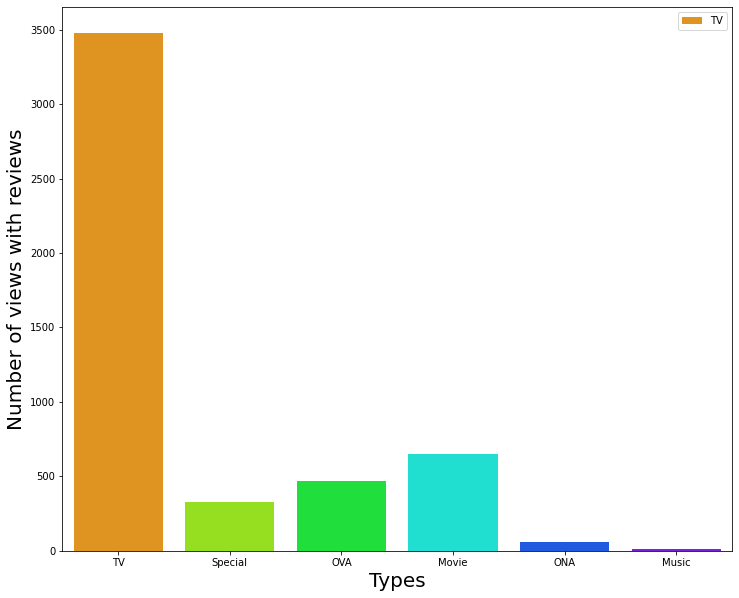

In [32]:
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.xlabel("Types", fontsize=20)
plt.ylabel("Number of views with reviews", fontsize=20)
plt.legend(sample['type'])
plt.show()

In [33]:
# analysis
data = sample[['user_id', 'anime_id', 'rating_x']]

reader = Reader(line_format='user item rating', sep='')
anime_loaded_data = Dataset.load_from_df(data, reader)
trainset, testset = train_test_split(anime_loaded_data, test_size=.2)

In [34]:
anime_loaded_data

In [35]:
svd = SVD()
svd.fit(trainset)

In [36]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 2.2788


2.278815481779953

In [37]:
params = {'n_factors': [20,50,100], 'reg_all': [.02, .05, .10]}
gridsearch_svd1 = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=3)

gridsearch_svd1.fit(anime_loaded_data)
print(gridsearch_svd1.best_score)
print(gridsearch_svd1.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.8s


{'rmse': 2.300031025292609, 'mae': 2.1926}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.0s finished


In [38]:
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
cv_knn_basic = cross_validate(knn_basic, anime_loaded_data, n_jobs=2)

for i in cv_knn_basic.items():
  print(i)
print('-----------')
print(np.mean(cv_knn_basic['test_rmse']))

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


('test_rmse', array([2.26847967, 2.34989361, 2.30325856, 2.29608362, 2.28254244]))
('test_mae', array([2.16 , 2.242, 2.193, 2.192, 2.176]))
('fit_time', (0.9357185363769531, 0.913374662399292, 0.8198580741882324, 0.9372386932373047, 0.47803211212158203))
('test_time', (0.022504091262817383, 0.04718971252441406, 0.060979604721069336, 0.06635618209838867, 0.03166794776916504))
-----------
2.3000515814465023


In [39]:
knn_basic_msd = KNNBasic(sim_options={'name':'msd', 'user-based':True})
cv_knn_basic_msd = cross_validate(knn_basic_msd, anime_loaded_data, n_jobs=2)
for i in cv_knn_basic_msd.items():
  print(i)
print('--------------')
print(np.mean(cv_knn_basic_msd['test_rmse']))

('test_rmse', array([2.28670068, 2.30629573, 2.33409511, 2.30997835, 2.26340452]))
('test_mae', array([2.183, 2.203, 2.222, 2.2  , 2.155]))
('fit_time', (0.19629645347595215, 0.22586488723754883, 0.21477770805358887, 0.3018925189971924, 0.2519834041595459))
('test_time', (0.012535572052001953, 0.029712438583374023, 0.029733657836914062, 0.02808237075805664, 0.02785801887512207))
--------------
2.3000948790439266


In [40]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based': True})
cv_knn_baseline = cross_validate(knn_baseline, anime_loaded_data, n_jobs=3)

for i in cv_knn_baseline.items():
  print(i)

print('-----------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([2.28100855, 2.30889584, 2.29521241, 2.34456819, 2.27068272]))
('test_mae', array([2.173, 2.207, 2.192, 2.235, 2.156]))
('fit_time', (0.5080568790435791, 0.6471426486968994, 0.9618539810180664, 0.5423414707183838, 0.6762523651123047))
('test_time', (0.03306388854980469, 0.014433860778808594, 0.020430564880371094, 0.027050495147705078, 0.03790283203125))
-----------------
2.3000735409163666


In [41]:
knn_pearson_baseline = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based':True})
cv_knn_pearson_baseline = cross_validate(knn_pearson_baseline, anime_loaded_data, n_jobs=3)
for i in cv_knn_pearson_baseline.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_pearson_baseline['test_rmse']))

('test_rmse', array([2.30499458, 2.29586585, 2.29085137, 2.29673682, 2.31257432]))
('test_mae', array([2.195, 2.185, 2.188, 2.191, 2.204]))
('fit_time', (0.4822499752044678, 0.7101447582244873, 0.6069936752319336, 0.38764166831970215, 0.336777925491333))
('test_time', (0.04053473472595215, 0.03891754150390625, 0.04512596130371094, 0.01310420036315918, 0.025753259658813477))
-------------------
2.300204587112992


In [42]:
knn_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
cv_knn_means = cross_validate(knn_means, anime_loaded_data, n_jobs=3)
for i in cv_knn_means.items():
  print(i)
print('------------')
print(np.mean(cv_knn_means['test_rmse']))

('test_rmse', array([2.2877937 , 2.30304147, 2.28538837, 2.31711027, 2.31711027]))
('test_mae', array([2.176, 2.194, 2.181, 2.215, 2.205]))
('fit_time', (0.7081539630889893, 0.6308012008666992, 0.7492122650146484, 0.4631016254425049, 0.30701684951782227))
('test_time', (0.041649818420410156, 0.04465365409851074, 0.041004180908203125, 0.01260066032409668, 0.013695478439331055))
------------
2.3020888144900757


In [43]:
param_grid = {'n_factors': [5, 20, 100],
            'n_epochs': [5,10],
            'lr_all': [.002, .005],
            'reg_all': [.02, .05, .5]}
svd_gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs=3, joblib_verbose=3)
svd_gs.fit(anime_loaded_data)
print(svd_gs.best_score)
print(svd_gs.best_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    1.5s


{'rmse': 2.3001954539396205, 'mae': 2.1926}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}}


[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    9.6s finished


In [44]:
#Now use this to fit test set, initial gridsearch was 2.77096, so will use that gs here
highest_perf_algo = gridsearch_svd1.best_estimator['rmse']
#retrain the whole set
trainset = anime_loaded_data.build_full_trainset()
highest_perf_algo.fit(trainset)
#Biased Accuracy on trainset
predictions = highest_perf_algo.test(trainset.build_testset())
print('Biased accuracy on Trainset', end='')
accuracy.rmse(predictions)
#UnBiased Accuracy on testset
predictions = highest_perf_algo.test(testset)
print('Unbiased Accuracy on test', end='')
accuracy.rmse(predictions)

Biased accuracy on TrainsetRMSE: 2.3002
Unbiased Accuracy on testRMSE: 2.2788


2.278815481779953

In [55]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [46]:
genre_tag = sample.loc[:, ['anime_id', 'name', 'genre']]
genre_tag.head()

,anime_id,name,genre
852257,30123,Akagami no Shirayuki-hime,"Drama, Fantasy, Romance, Shoujo"
2321054,10739,Panty &amp; Stocking in Sanitarybox,"Action, Comedy, Dementia, Ecchi, Parody, Super..."
1171632,1606,Kekkaishi,"Adventure, Comedy, Fantasy, Shounen"
1662933,443,Onegai☆Teacher: Himitsu na Futari,"Comedy, Ecchi, Romance, Sci-Fi"
941433,15451,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."


In [47]:
tags = {}
for col in ['genre']:
  for a_id in sample['name'].unique():
    for i in sample[sample['name'] == a_id][col]:
      if a_id in tags:
        tags[a_id].append(' '.join(i.lower().split('|')))
      else:
        tags[a_id] = i.lower().split('|')
      

In [48]:
tags_list = list(tags.values())
tags_list[:5]

[['drama, fantasy, romance, shoujo', 'drama, fantasy, romance, shoujo'],
 ['action, comedy, dementia, ecchi, parody, supernatural',
  'action, comedy, dementia, ecchi, parody, supernatural'],
 ['adventure, comedy, fantasy, shounen',
  'adventure, comedy, fantasy, shounen'],
 ['comedy, ecchi, romance, sci-fi'],
 ['action, comedy, demons, ecchi, harem, romance, school',
  'action, comedy, demons, ecchi, harem, romance, school',
  'action, comedy, demons, ecchi, harem, romance, school',
  'action, comedy, demons, ecchi, harem, romance, school',
  'action, comedy, demons, ecchi, harem, romance, school']]

In [51]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [52]:
def process_article(article):
  article = ' '.join(article)
  tokens = word_tokenize(article)
  tokens_2 = []
  for token in tokens:
    if token.lower() not in stopwords_list:
      tokens_2.append(token.lower())
  return tokens_2

In [56]:
process_tags = list(map(process_article, tags_list))

In [57]:
articles_concat = []
for doc in process_tags:
  articles_concat += doc

In [58]:
freqdist = FreqDist(articles_concat)
freqdist

FreqDist({'comedy': 2403, 'action': 2142, 'romance': 1578, 'drama': 1282, 'supernatural': 1282, 'shounen': 1279, 'fantasy': 1265, 'school': 1228, 'sci-fi': 1051, 'adventure': 1048, ...})

In [60]:
most_common_genre = freqdist.most_common(20)
most_common_genre

[('comedy', 2403),
 ('action', 2142),
 ('romance', 1578),
 ('drama', 1282),
 ('supernatural', 1282),
 ('shounen', 1279),
 ('fantasy', 1265),
 ('school', 1228),
 ('sci-fi', 1051),
 ('adventure', 1048),
 ('slice', 720),
 ('life', 720),
 ('mystery', 587),
 ('ecchi', 578),
 ('super', 523),
 ('power', 523),
 ('harem', 518),
 ('seinen', 486),
 ('magic', 464),
 ('mecha', 393)]

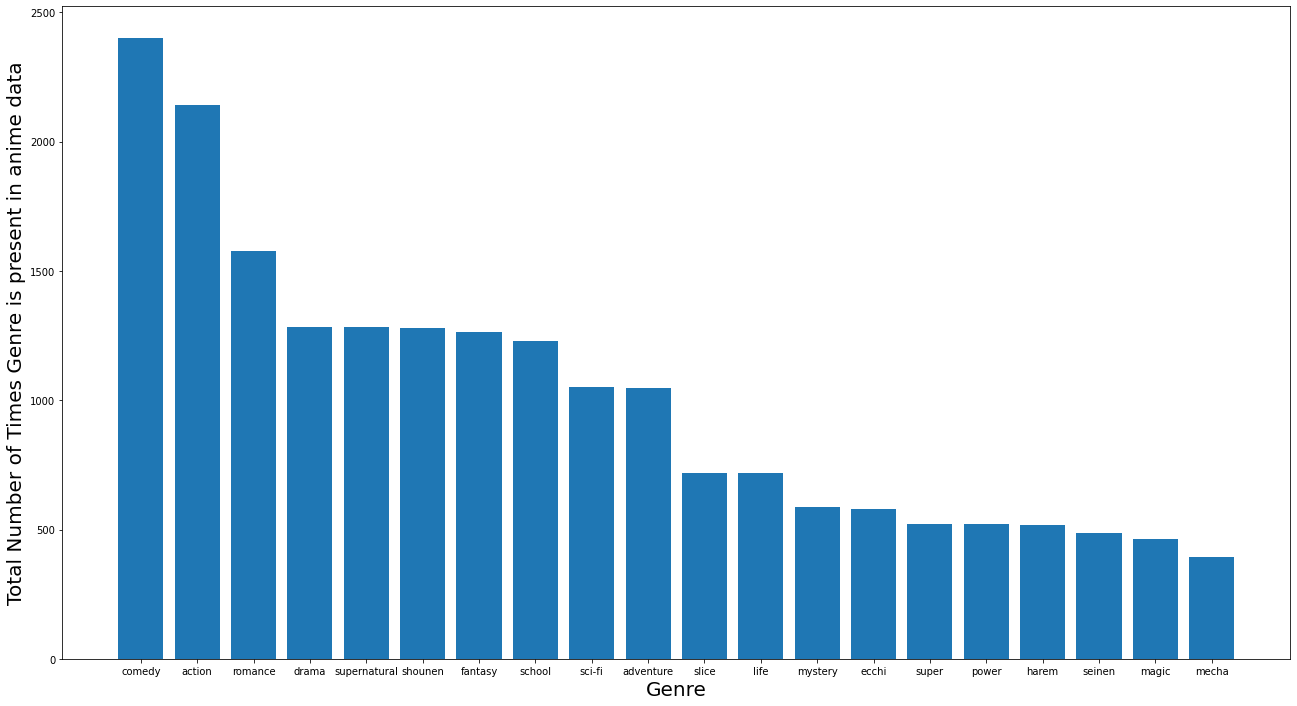

In [65]:
plt.figure(figsize=(22, 12))
plt.bar([word[0] for word in most_common_genre], [word[1] for word in most_common_genre])
plt.xlabel("Genre", fontsize=20)
plt.ylabel("Total Number of Times Genre is present in anime data", fontsize=20)
plt.show()

In [70]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words=stopwords_list)
tags_list_2 = [' '.join(x) for x in tags_list]
tf_idf_data_train = vectorizer.fit_transform(tags_list_2)

In [72]:
#instatiate SVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
#fit and transfrom the vectorized tf-idf matrix
tf_idf_data_train_svd = svd.fit_transform(tf_idf_data_train)

In [73]:
print(svd.explained_variance_ratio_.sum())

0.9959038187446219
